In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from afqinsight.nn.utils import prep_fa_dataset, reconstruction_loss, vae_loss, kl_divergence_loss, prep_first_tract_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from sklearn.decomposition import PCA
import afqinsight.augmentation as aug
import pandas as pd
import seaborn as sns
from afqinsight.nn.pt_models import VariationalAutoencoder


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import sys 
sys.path.insert(1, '/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils')

In [15]:
from utils import train_variational_autoencoder, select_device

ImportError: cannot import name 'select_device' from 'utils' (/Users/samchou/AFQ-Insight-Autoencoder-Experiments/AFQ-Insight-Autoencoder-Experiments/Experiment_Utils/utils.py)

In [4]:
# FIRST TRACT DATASET
# VARIATIONAL 
# CONVOLUTIONAL AUTOENCODER
# TESTING LATENT AND DROPOUT SIMULTATENTOUSLY 

In [5]:
device = select_device()

In [6]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/src/nrdg/AFQ-Insight/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [7]:
torch_dataset, first_tract_train_loader, first_tract_test_loader, first_tract_val_loader = prep_first_tract_data(
    dataset, batch_size=64
)

In [11]:
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
models = {}
results = {}

for dropout in dropout_values:
    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim} and Dropout: {dropout}")
        
        # Initialize a new autoencoder for each latent dimension
        test_model = VariationalAutoencoder(input_shape= 100, latent_dims=latent_dim, dropout=dropout).to(device)
        
        # Train the model 
        training_results = train_variational_autoencoder(test_model, first_tract_train_loader, 
                                                         first_tract_val_loader, 100, 0.001, device = device)
        
        # Store both the model and results
        models[latent_dim, dropout] = test_model
        results[latent_dim, dropout] = training_results
        
        print(f"Completed training for latent_dim={latent_dim}, Best Val RMSE: {training_results['best_val_rmse']:.4f}")


Training Autoencoder with Latent Dimension: 2 and Dropout: 0.0
Saving best model state with RMSE: 0.3871314415963597
Epoch 1, Train RMSE: 0.4883, Val RMSE: 0.3871, KL: 0.1476, Recon Loss (Train): 24.2069, Recon Loss (Val): 4.2776
Completed training for latent_dim=2, Best Val RMSE: 0.3871
Training Autoencoder with Latent Dimension: 4 and Dropout: 0.0
Saving best model state with RMSE: 0.35363722196390796
Epoch 1, Train RMSE: 0.4704, Val RMSE: 0.3536, KL: 0.2038, Recon Loss (Train): 22.5310, Recon Loss (Val): 3.3775
Completed training for latent_dim=4, Best Val RMSE: 0.3536
Training Autoencoder with Latent Dimension: 8 and Dropout: 0.0
Saving best model state with RMSE: 0.34185767293375074
Epoch 1, Train RMSE: 0.4509, Val RMSE: 0.3419, KL: 0.7226, Recon Loss (Train): 20.6909, Recon Loss (Val): 3.2582
Completed training for latent_dim=8, Best Val RMSE: 0.3419
Training Autoencoder with Latent Dimension: 16 and Dropout: 0.0
Saving best model state with RMSE: 0.28769057899414496
Epoch 1, Tra

Latent Dim: 2, Dropout: 0.0
Latent Dim: 2, Dropout: 0.1
Latent Dim: 2, Dropout: 0.5
Latent Dim: 4, Dropout: 0.0
Latent Dim: 4, Dropout: 0.1
Latent Dim: 4, Dropout: 0.5
Latent Dim: 8, Dropout: 0.0
Latent Dim: 8, Dropout: 0.1
Latent Dim: 8, Dropout: 0.5
Latent Dim: 16, Dropout: 0.0
Latent Dim: 16, Dropout: 0.1
Latent Dim: 16, Dropout: 0.5
Latent Dim: 32, Dropout: 0.0
Latent Dim: 32, Dropout: 0.1
Latent Dim: 32, Dropout: 0.5
Latent Dim: 64, Dropout: 0.0
Latent Dim: 64, Dropout: 0.1
Latent Dim: 64, Dropout: 0.5
Latent Dim: 100, Dropout: 0.0
Latent Dim: 100, Dropout: 0.1
Latent Dim: 100, Dropout: 0.5


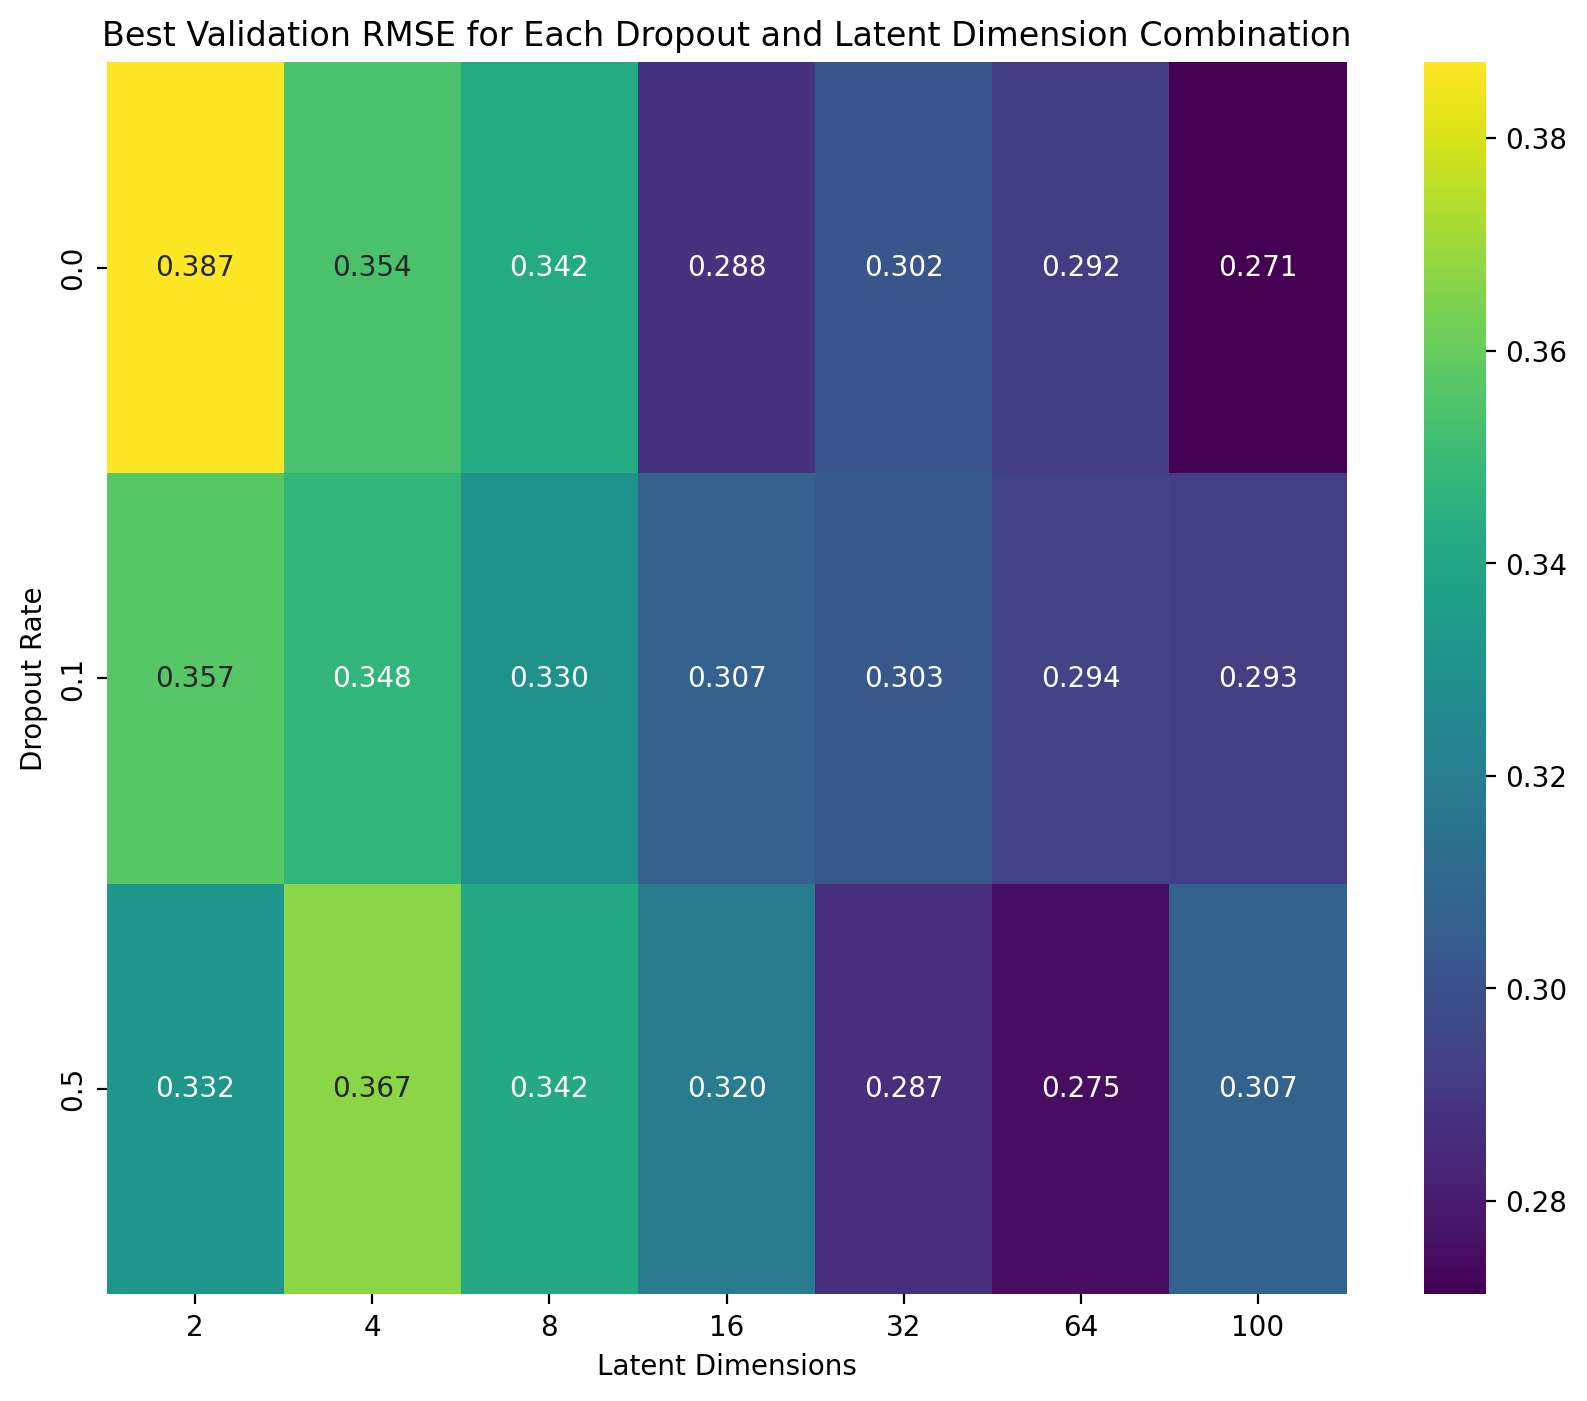

In [12]:
# Create a DataFrame with rows for dropout and columns for latent_dims
latent_dims = [2, 4, 8, 16, 32, 64, 100]
dropout_values = [0.0, 0.1, 0.5]
df_best_val = pd.DataFrame(index=dropout_values, columns=latent_dims)

# Populate the DataFrame with the best validation RMSE values
for latent_dim in latent_dims:
    for dropout in dropout_values:
        print(f"Latent Dim: {latent_dim}, Dropout: {dropout}")  
        key = (latent_dim, dropout)
        if key in results:
            best_val_loss = results[key]["best_val_rmse"]
            df_best_val.loc[dropout, latent_dim] = best_val_loss
        else:
            print(f"Key {key} not found in results.")
            # Handle missing key, e.g., set a default value
            df_best_val.loc[dropout, latent_dim] = np.nan  # or any other default


# Convert the values to floats (if they aren't already)
df_best_val = df_best_val.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_best_val, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("Latent Dimensions")
plt.ylabel("Dropout Rate")
plt.title("Best Validation RMSE for Each Dropout and Latent Dimension Combination")
plt.show()
